In [ ]:
# Colab only: Run this cell to download/install packages
import sys

# Relational Data and Visualization
In this problem, you will be analyzing the Twitter data we extracted using [this](https://developer.twitter.com/en/docs/twitter-api) api, in 2016. The data consists of Twitter users (with unique handles) and their attributes (e.g., number of followers), some recent tweets posted by them with attributes (e.g., time stamp, number of retweets), and the follow relationship between the users. These are available in the three (gzipped) CSV files provided to you:
- users.csv.gz - users, user attributes
- edges.csv.gz - follow edges (directed, an edge from A to B means A follows B or B is a friend of A)
- tweets.csv.gz - tweets posted by the users along with its attributes

In [ ]:
import gzip
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Q1. Relational Data
This question will guide you through loading Twitter data into an in-memory SQLite database and running some basic queries on it.

### Q1. Task A: Load Twitter data into SQLite database
Your first task is to use the (gzipped) csv and sqlite3 python packages to load the three csv files we give you as relations (or tables) into an SQLite in-memory database.

Loading the data from (gzipped) csv file into the database involves the following steps:
1. Identify the schema of the table (for this problem, you will only need TEXT and INTEGER attribute types)
2. Create a table with the identified schema
3. Load the contents of csv in memory
4. Insert every row of csv file as a record in the table

You can refer to [sqlite3 documentation](https://docs.python.org/2/library/sqlite3.html) and the class lecture for steps 2 and 4. For step 3 you can use pandas. Be sure to name your tables `users`, `edges`, and `tweets`.

Make sure to commit (the equivalent of Ctrl+S for databases) any changes you make to the database. [This](https://www.techopedia.com/definition/16/commit) page should give you an idea about why commit is essential.

Don't decompress the `.gz` files - we do that while reading them, i.e., pass the `*.csv.gz` filenames directly into a pandas function. This is common practice when dealing with large amounts of text data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_twitter_data_sqlite3(conn):
    """ Load twitter data in the three files as tables into an in-memory SQLite database.
    The tables are stored in the following three csv files:
      - users.csv.gz
      - edges.csv.gz
      - tweets.csv.gz
    You should inspect the files and create a database schema with the same columns as in the csv file,
    and either "TEXT" or "INTEGER" types.
    Input:
        conn (sqlite3.Connection) : Connection object corresponding to the database; used to perform SQL commands.
    Output:
        conn : Return connection after performing commands
    """

    users_file = '/content/drive/MyDrive/Colab Notebooks/users.csv.gz'
    edges_file = '/content/drive/MyDrive/Colab Notebooks/edges.csv.gz'
    tweets_file = '/content/drive/MyDrive/Colab Notebooks/tweets.csv.gz'

    users_df = pd.read_csv(users_file, compression='gzip')
    edges_df = pd.read_csv(edges_file, compression='gzip')
    tweets_df = pd.read_csv(tweets_file, compression='gzip')

    users_df.to_sql('users', conn, if_exists='replace', index=False)
    edges_df.to_sql('edges', conn, if_exists='replace', index=False)
    tweets_df.to_sql('tweets', conn, if_exists='replace', index=False)

    conn.commit()

    return conn

conn = sqlite3.connect(':memory:')

load_twitter_data_sqlite3(conn)

### Q1. Task B: Trending tweets in a topic
Twitter is regarded as an invaluable source of valuable information. Hence, one of the favorite tasks of data miners is to analyze the trending tweets in a given topic.

This task requires you to retrieve the top N most trending tweets (in descending order of trending_score) about a given topic (which is a list of keywords). The following information may be useful:

- A tweet is said to be about a given topic if it contains any of the given topical phrases/keywords.
- We will use the following simple trending_score: retweet_count + favorite_count. Tweets with higher trending_score must be ranked before the ones with lower trending_score.
- Your result must contain unique tweets. If a tweet text occurs multiple times, display it only once with its highest trending_score.
- Break ties by sorting the tweets in alphabetical order.

The output schema should be as follows:

|tweet (TEXT)| trending_score (INTEGER) |
| :--- |:--- |
| | |



In [ ]:
def trending_tweets(cursor, topical_phrases, N):
    """ Retrieves the top N trending tweets containing one or more of the given topical phrases.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
        topical_phrases (list of strings): A list of keywords identifying a topic.
        N: Number of trending tweets to retrieve
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """
    topical_query = " OR ".join([f"tweet_text LIKE '%{phrase}%'" for phrase in topical_phrases])

    query = f"""
    SELECT tweet_text, MAX(retweet_count + favorite_count) AS trending_score
    FROM tweets
    WHERE {topical_query}
    GROUP BY tweet_text
    ORDER BY trending_score DESC, tweet_text ASC
    LIMIT {N}
    """

    results = cursor.execute(query)
    return results

### Q1. Task C: Tweet recommendation
How does Twitter go about populating the feed for a user? While Twitter may compile models to do this, in this task, we will use a Simple Tweet Recommender (STR), which recommends a user's tweets to all users who follow them (without checking for possible duplicates; i.e., STR may recommend the same tweet twice if two of a user's friends have posted it).

In this task, you will write a query to determine the number of tweets recommended to each user. Use only the snapshot of edges and tweets we have provided to do the recommendation. Report the results on the users present in the users table. (Hint: The number of records in your output should match that in the "users" table.) The order of results does not matter.

The output schema should be:

|screen_name (TEXT)| num_tweets (INTEGER) |
| :--- |:--- |
| | | |


In [ ]:
def num_tweets_in_feed(cursor):
    """ Retrieves the number of tweets STR recommends to each Twitter user.
    Input:
        cursor (sqlite3.Cursor): Cursor object to query the database.
    Output:
        results (sqlite3.Cursor): Cursor object which can be used to iterate over the retrieved records/tuples.
    """
    query = """
    SELECT u.user_handle, COUNT(t.tweet_id) AS num_recommended_tweets
    FROM users u
    LEFT JOIN edges e ON u.user_handle = e.user1_handle
    LEFT JOIN tweets t ON e.user2_handle = t.user_handle
    GROUP BY u.user_handle
    """

    results = cursor.execute(query)
    return results

## Q2. Visualization
In this question, you will load all data into pandas dataframes and analyze (and visualize!) some interesting trends using [matplotlib](http://matplotlib.org) python package.

### Q2. Task A: Load Twitter data using pandas
Fill in the following method stub and return the data frames for users, edges and tweets.

Pandas will treat missing values as NaNs by default. However, for this assignment, you should treat missing values (i.e., empty strings in the csv files) as empty strings.

In [ ]:
def load_twitter_data_pandas():
    """ Load twitter data in the three files as pandas data frames.
    The tables are stored in the following three csv files:
      - users.csv.gz
      - edges.csv.gz
      - tweets.csv.gz
    Output:
        users_df, edges_df, tweets_df,
        conn : Return connection after performing commands
    """

    users_file = '/content/drive/MyDrive/Colab Notebooks/users.csv.gz'
    edges_file = '/content/drive/MyDrive/Colab Notebooks/edges.csv.gz'
    tweets_file = '/content/drive/MyDrive/Colab Notebooks/tweets.csv.gz'

    users_df = pd.read_csv(users_file, compression='gzip', na_filter=False)
    edges_df = pd.read_csv(edges_file, compression='gzip', na_filter=False)
    tweets_df = pd.read_csv(tweets_file, compression='gzip', na_filter=False)

    return users_df, edges_df, tweets_df

users_df, edges_df, tweets_df = load_twitter_data_pandas()

### Q2. Task B: Correlation
Statisticians and data analysts usually like to study the correlation between different observed variables. This helps uncover interesting patterns in the data such as causal relationships (e.g., snow on the road leads to an increase in the number of accidents). Correlation studies are important for multiple reasons:
- While [correlation does not imply causation](https://en.wikipedia.org/wiki/Correlation_does_not_imply_causation), a lack of correlation implies a lack of causation. This can be used to rule out many causal relationships.
- Correlation helps with prediction. The more closely related two variables are, the easier it is to predict one from the other.

In this task, we ask you to plot the friends_count (on y-axis) vs the followers_count (on x-axis) using the matplotlib package. [Here](http://matplotlib.org/examples/shapes_and_collections/scatter_demo.html) is an example to get started with scatter plots.

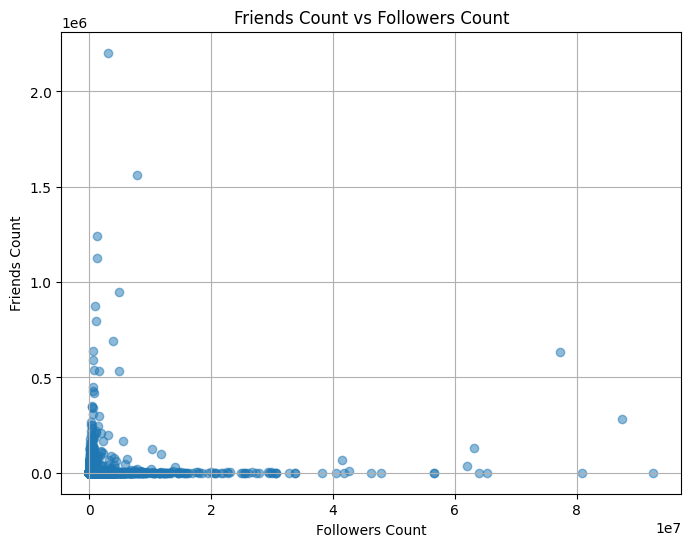

In [ ]:
def plot_friends_vs_followers(users_df):
    """ Plots the friends_count (on y-axis) against the followers_count (on x-axis).
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (matplotlib.collections.PathCollection) : The object returned by the scatter plot function
    """
    plt.figure(figsize=(8, 6))
    scatter_plot = plt.scatter(users_df['followers_count'], users_df['friends_count'], alpha=0.5)
    plt.xlabel('Followers Count')
    plt.ylabel('Friends Count')
    plt.title('Friends Count vs Followers Count')
    plt.grid(True)
    plt.show()
    return scatter_plot


plot_friends_vs_followers(load_twitter_data_pandas()[0]);

Do you see a correlation between these two variables from your scatter plot? Let's measure this quantitatively using the [Pearson's correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).

For a set of observations $(X,Y) = [(x_1,y_1), (x_2,y_2), ... , (x_n,y_n)]$, the Pearson's correlation coefficient is a measure of the linear dependence between two variables $X$ and $Y$, giving a value between +1 and −1 inclusive, where 1 is total positive correlation, 0 is no correlation, and −1 is total negative correlation.

$r=r_{xy}={\frac {n\sum x_{i}y_{i}-\sum x_{i}\sum y_{i}}{{\sqrt {n\sum x_{i}^{2}-(\sum x_{i})^{2}}}~{\sqrt {n\sum y_{i}^{2}-(\sum y_{i})^{2}}}}}$

Now, fill in the following function to compute the Pearson's correlation coefficient between friends_count and followers_count.

In [ ]:
def correlation_coefficient(users_df):
    """ Computes correlation between user followers and friendss
    Input:
        users_df (pd.DataFrame) : Dataframe containing Twitter user attributes,
                                    as returned by load_twitter_data_pandas()
    Output:
        (double) : correlation coefficient between friends_count and followers_count
    """
    correlation = users_df['followers_count'].corr(users_df['friends_count'])
    return correlation

corr_coefficient = correlation_coefficient(load_twitter_data_pandas()[0])
print("Pearson's correlation coefficient:", corr_coefficient)

Pearson's correlation coefficient: 0.09308640516482451


### Q2. Task C: Degree distribution
If you are not familiar with graph theory and/or graph mining, skip the first paragraph.

As you're familiar with graphs, you might know that the degree of a node is the number of connections it has to other nodes. A common statistic to look out for in the case of real-world graphs is the degree distribution. Literature says degrees of nodes in real-world graphs follow a [power law distribution](https://en.wikipedia.org/wiki/Power_law). The implication is that a scatter plot of num_users versus k (as we will define below) yields an almost straight line. In this task, we shall verify whether the given crawl of the Twitter network satisfies this property.

Let us call the number of friends a Twitter user has as his/her degree. The degree distribution is a histogram of the number of friends. Your task is to visualize this histogram. Use the default number of bins.

Do you notice any surprising/unexpected patterns? What can you say about the way in which the Twitter data was collected?

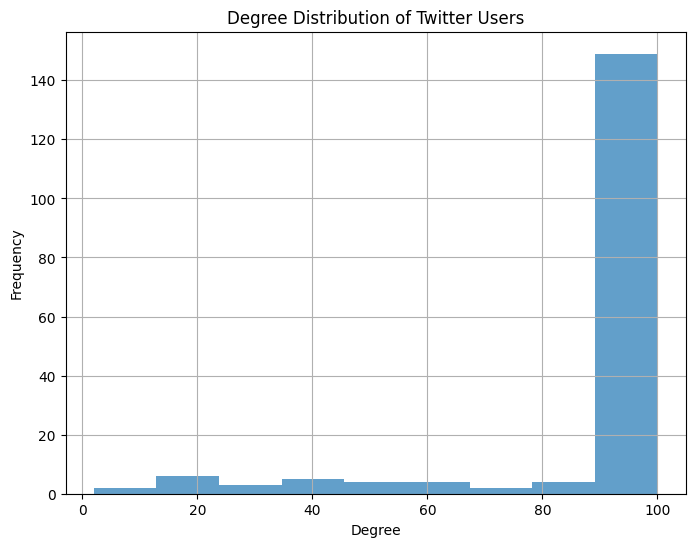

(array([  2.,   6.,   3.,   5.,   4.,   4.,   2.,   4., 149.]),
 array([  2.        ,  12.88888889,  23.77777778,  34.66666667,
         45.55555556,  56.44444444,  67.33333333,  78.22222222,
         89.11111111, 100.        ]),
 <BarContainer object of 9 artists>)

In [ ]:
def degree_distribution(edges_df):
    """ Plots the distribution of friends for users.
    Input:
        edges_df (pd.DataFrame) : Dataframe containing Twitter edges,
                        as returned by load_twitter_data_pandas()
    Output:
        (array, array, list of Patch objects) : Tuple of the values of the histogram bins,
                        the edges of the bins and the silent list of individual patches used to create the histogram.
                        Note that this format is exactly what is output by the `plt.hist` function.
    """
    degree_counts = edges_df['screen_name'].value_counts().reset_index()
    degree_counts.columns = ['screen_name', 'degree']

    plt.figure(figsize=(8, 6))
    values, edges, patches = plt.hist(degree_counts['degree'], bins='auto', alpha=0.7)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Degree Distribution of Twitter Users')
    plt.grid(True)
    plt.show()

    return values, edges, patches

degree_distribution(load_twitter_data_pandas()[1])